## How is socioeconomic status of a district correlated with (i) the response time and (ii) the number of calls received per person?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### Data Loading

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/My Drive/EMS Data/Time_Dataset.csv")

In [ ]:
df_original = df.copy()

In [ ]:
df.head()

,INCIDENT_DATETIME,FINAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,BOROUGH,COMMUNITYDISTRICT
0,01/01/2021 12:00:21 AM,2,101,433.0,QUEENS,410
1,01/01/2021 12:01:03 AM,4,49,189.0,MANHATTAN,101
2,01/01/2021 12:01:05 AM,7,34,476.0,BRONX,203
3,01/01/2021 12:01:12 AM,3,94,559.0,BROOKLYN,313
4,01/01/2021 12:01:26 AM,7,13,1026.0,BROOKLYN,316


In [ ]:
df_income = pd.read_csv("/content/drive/My Drive/EMS Data/Median Income.csv")

In [ ]:
df_income.head()

,Community Districts,Neighborhood Code,All Households,Families,Families with Children,Families without Children
0,Astoria,Q01,"$73,539","$87,841","$78,430","$93,787"
1,Battery Park/Tribeca,M01,"$57,565","$87,681","$100,961","$80,001"
2,Bay Ridge,K10,"$73,633","$92,790","$94,791","$90,774"
3,Bayside,Q11,"$86,731","$103,806","$93,717","$105,514"
4,Bedford Park,B07,"$37,648","$43,001","$35,855","$55,861"


In [ ]:
print(df.sort_values(by='COMMUNITYDISTRICT')['COMMUNITYDISTRICT'].unique())
print(df_income.sort_values(by='Neighborhood Code')['Neighborhood Code'].unique())

[101 102 103 104 105 106 107 108 109 110 111 112 164 201 202 203 204 205
 206 207 208 209 210 211 212 226 227 228 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 355 356 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 480 481 482 483 484 501 502 503 595]
['B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B10' 'B11' 'B12'
 'K01' 'K02' 'K03' 'K04' 'K05' 'K06' 'K07' 'K08' 'K09' 'K10' 'K11' 'K12'
 'K13' 'K14' 'K15' 'K16' 'K17' 'K18' 'M01' 'M02' 'M03' 'M04' 'M05' 'M06'
 'M07' 'M08' 'M09' 'M10' 'M11' 'M12' 'Q01' 'Q02' 'Q03' 'Q04' 'Q05' 'Q06'
 'Q07' 'Q08' 'Q09' 'Q10' 'Q11' 'Q12' 'Q13' 'Q14' 'S01' 'S02' 'S03']


### Data Preprocessing
The neighborhoods are represented using two different methods. The income dataset has a borough letter followed by a two-digit number, while the EMS dataset uses a three-digit number where the first digit tells us which borough it is.

In [ ]:
mapping = {1: 'M', 2: 'B', 3: 'K', 4: 'Q', 5: 'S'}

def convert_to_string(value):
    hundreds = value // 100
    tens_units = value % 100
    letter = mapping.get(hundreds, '')
    return f"{letter}{tens_units:02d}"

df['Neighborhood Code'] = df['COMMUNITYDISTRICT'].apply(convert_to_string)

filtered_df = df[df['Neighborhood Code'].isin(df_income['Neighborhood Code'])]

filtered_df.head()

,INCIDENT_DATETIME,FINAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,BOROUGH,COMMUNITYDISTRICT,Neighborhood Code
0,01/01/2021 12:00:21 AM,2,101,433.0,QUEENS,410,Q10
1,01/01/2021 12:01:03 AM,4,49,189.0,MANHATTAN,101,M01
2,01/01/2021 12:01:05 AM,7,34,476.0,BRONX,203,B03
3,01/01/2021 12:01:12 AM,3,94,559.0,BROOKLYN,313,K13
4,01/01/2021 12:01:26 AM,7,13,1026.0,BROOKLYN,316,K16


In [ ]:
mean_df = filtered_df.groupby('Neighborhood Code').agg(
    DISPATCH_RESPONSE_SECONDS_QY=('DISPATCH_RESPONSE_SECONDS_QY', 'mean'),
    INCIDENT_TRAVEL_TM_SECONDS_QY=('INCIDENT_TRAVEL_TM_SECONDS_QY', 'mean'),
    FINAL_SEVERITY_LEVEL_CODE=('FINAL_SEVERITY_LEVEL_CODE', 'mean'),
    Frequency=('Neighborhood Code', 'size'),
    BOROUGH=('BOROUGH', 'first')
).reset_index()
mean_df = pd.merge(mean_df, df_income[['Neighborhood Code', 'All Households']], on='Neighborhood Code', how='left')
mean_df['All Households'] = mean_df['All Households'].str.replace('[\$,]', '', regex=True).astype(int)

mean_df.head()

,Neighborhood Code,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FINAL_SEVERITY_LEVEL_CODE,Frequency,BOROUGH,All Households
0,B01,61.678637,457.009479,4.282694,37369,BRONX,19205
1,B02,55.435478,493.700114,4.248769,18885,BRONX,10966
2,B03,60.619936,449.983993,4.330632,31963,BRONX,14750
3,B04,57.307643,449.260677,4.351236,38951,BRONX,41636
4,B05,58.283679,468.602955,4.283361,34539,BRONX,34894


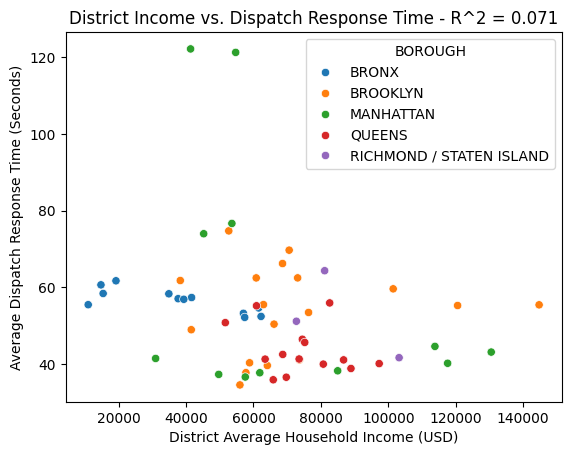

In [ ]:
sns.scatterplot(data=mean_df, x='All Households', y='DISPATCH_RESPONSE_SECONDS_QY', hue='BOROUGH')

corr = mean_df['All Households'].corr(mean_df['DISPATCH_RESPONSE_SECONDS_QY'])
rsq = corr ** 2

plt.xlabel('District Average Household Income (USD)')
plt.ylabel('Average Dispatch Response Time (Seconds)')
plt.title(f'District Income vs. Dispatch Response Time - R^2 = {rsq:.3f}')

plt.show()

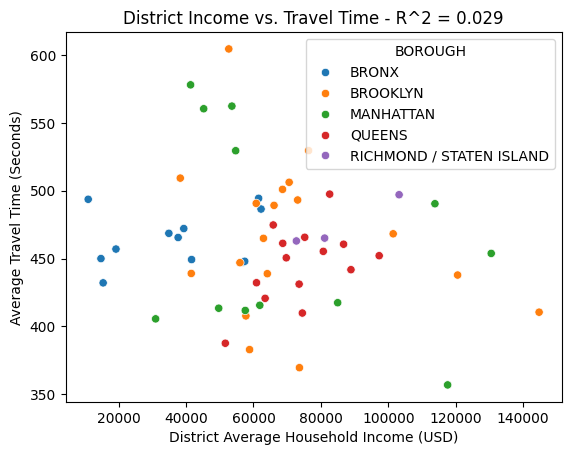

In [ ]:
sns.scatterplot(data=mean_df, x='All Households', y='INCIDENT_TRAVEL_TM_SECONDS_QY', hue='BOROUGH')

corr = mean_df['All Households'].corr(mean_df['INCIDENT_TRAVEL_TM_SECONDS_QY'])
rsq = corr ** 2

plt.xlabel('District Average Household Income (USD)')
plt.ylabel('Average Travel Time (Seconds)')
plt.title(f'District Income vs. Travel Time - R^2 = {rsq:.3f}')

plt.show()

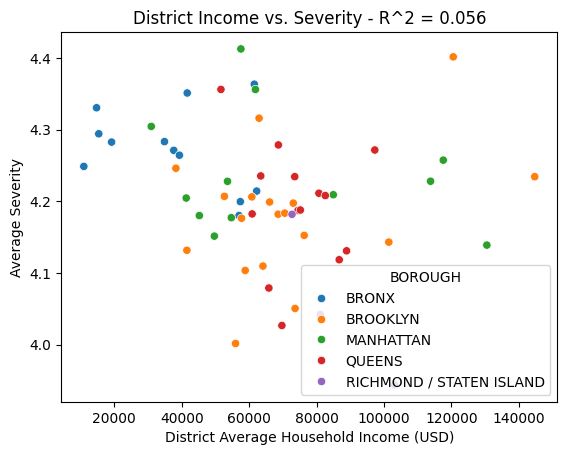

In [ ]:
sns.scatterplot(data=mean_df, x='All Households', y='FINAL_SEVERITY_LEVEL_CODE', hue='BOROUGH')

corr = mean_df['All Households'].corr(mean_df['FINAL_SEVERITY_LEVEL_CODE'])
rsq = corr ** 2

plt.xlabel('District Average Household Income (USD)')
plt.ylabel('Average Severity')
plt.title(f'District Income vs. Severity - R^2 = {rsq:.3f}')

plt.show()